In [1]:
import numpy as np
from scipy import integrate as integ
from scipy import signal as signal
import sympy as sp
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets
from tqdm import tqdm
import multiprocessing
###
from turing_model import TuringModel as tm

In [2]:
#@jit
def slow(var, t, d_Hmax1, d_Hmax2):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    d_H1a = var[8]
    d_H2a = var[9]
    d_H1b = var[10]
    d_H2b = var[11]
    H1_loss = var[12]
    H2_loss = var[13]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # inflection points
    x_01 = D / (a_1 * (e - h * D))
    x_02 = D / (a_2 * (e - h * D))

    # dispersal rates of competitors
    d_H1a = d_Hmax1 / (1 + np.exp(k_1 * (A_a - x_01)))
    d_H1b = d_Hmax1 / (1 + np.exp(k_1 * (A_b - x_01)))
    d_H2a = d_Hmax2 / (1 + np.exp(k_2 * (A_a - x_02)))
    d_H2b = d_Hmax2 / (1 + np.exp(k_2 * (A_b - x_02)))

    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    H1_loss = d_H1a-(d_H1a * dH_1a)/(1 + np.exp(k_1 * (A_a - x_01)))
    H2_loss = d_H2a-(d_H2a * dH_2a)/(1 + np.exp(k_2 * (A_a - x_02)))

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, d_H1a, d_H2a, d_H1b, d_H2b, H1_loss, H2_loss)

In [3]:
# var
var = []

# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

# adaptability
k_1 = 0 # dispersal adaptability of competitor 1 
k_2 = 2 # dispersal adaptability of competitor 2 
        # 0 = random dispersal, 2 = adaptive dispersal

# dispersal speed 


In [4]:
t_end = 100 #4000  # 100000
number_steps = 100 #2000  # 25000
t = np.linspace(0, t_end, number_steps)
# dispersal adaptability
k_1 = 5
k_2 = 0
# maximum dispersal rate
# d_Hmax1 = 10**-2
# d_Hmax2 = 10**-2
d_Hmax_range = np.logspace(-3, 1, 6)

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
var = []
#meandensity_H1x = np.zeros(((len(d_Hmax_range)),(len(d_Hmax_range))))
meandensity_H1x = np.zeros((len(d_Hmax_range)))
i=0
j=0
def fast(i): #(i,j)
    k_1 = 5
    k_2 = 0	
    t_end = 100
    number_steps = 100
    t = np.linspace(0, t_end, number_steps)
    var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
    var = []
    d_Hmax1 = d_Hmax_range[i]
    d_Hmax2 = 1#d_Hmax_range[j]
    var = integ.odeint(slow, var0, t, args=(d_Hmax1 , d_Hmax2))
    meandensity_H1x[i] = np.mean(var[-200:-1, 4]) # [i,j]
    # if i == 0 and j == 5:
    #     print(np.mean(var[-200:-1, 4]))
    return(var)

In [5]:
meandensity_H1x = np.zeros(((len(d_Hmax_range)),(len(d_Hmax_range))))

i = 0
j = 0

with multiprocessing.get_context("spawn").Pool(6) as pool:
    pool.map(fast, [1,2,3])

#processes = []

# for d_Hmax2 in d_Hmax_range:
#     j = 0
# for d_Hmax1 in d_Hmax_range:
#     #processes.append(multiprocessing.Process(target=fast, args=(d_Hmax_range,i,j)))
#     with multiprocessing.Pool(6) as pool:
#         pool.map(fast, d_Hmax_range)
#     j += 1
# i += 1

# for process in processes:
#     process.start()
# for process in processes:
#     process.join()

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


<Axes: >

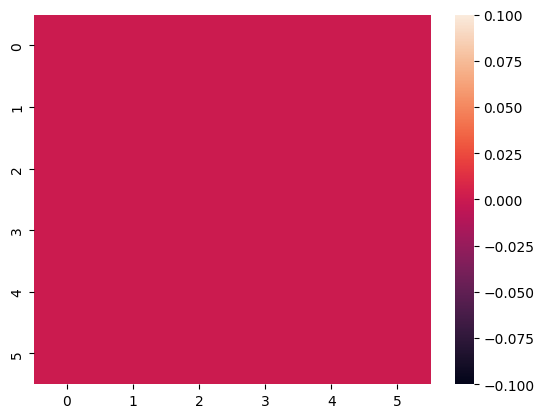

In [10]:
print(meandensity_H1x)
sns.heatmap(meandensity_H1x)